In [8]:
## Stan Biryukov
## Demonstrate bayesian neural network on myocardial infarction in Worcester cohort  
## 2/7/18
import os
import subprocess
CORES = int(subprocess.check_output("grep '^core id' /proc/cpuinfo |sort -u|wc -l",shell=True).decode('utf-8').strip())
# os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"
# os.environ["OMP_NUM_THREADS"] = str(CORES)
# os.environ["openmp"] = "True"
os.environ["THEANO_FLAGS"]='blas.ldflags="-L/usr/lib/ -lblas"'
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
import numpy as np
import lasagne
import edward as ed
import scipy as sp
SEED = 7162
np.random.seed(SEED)

## read in Worcester data and, for now, ignore the time to event component to speed up sampling
## given the covariates, predict heart attack: FSTAT==1
df = pd.read_csv('/home/j/temp/stan/worcester_heart_wide.csv',index_col=0).astype(np.float32)
df['ID'] = pd.factorize(df['ID'])[0]
df.rename(columns={'FSTAT': 'y'}, inplace=True)

cols = ['y']  + [col for col in df if col != 'y']
df = df[cols]
group = df[['ID']]

df.drop(['ID'],axis=1,inplace=True)

X_df = df[df.columns[1:]]
Y_df = df[df.columns[0:1]]
X = df[df.columns[1:]].astype(np.float32).as_matrix()
Y = df[df.columns[0:1]].astype(np.float32).as_matrix().ravel()
group = group['ID'].astype(np.int32).as_matrix()

## normalize
X = StandardScaler().fit_transform(X).astype(np.float32)
train_inds, test_inds = next(GroupShuffleSplit(random_state=SEED,test_size=.2).split(X, Y, groups=group))
X_train, X_test, Y_train, Y_test, group_train, group_test = X[train_inds], X[test_inds], Y[train_inds], Y[test_inds], group[train_inds], group[test_inds]

X_train.shape
Y_train.shape
sum(Y_test)/len(Y_test)
sum(Y_train)/len(Y_train)
print(CORES)

df.head()

14


,y,AGE,GENDER,HR,SYSBP,DIASBP,BMI,CVD,AFB,SHO,CHF,AV3,MIORD,MITYPE,YEAR,LOS,DSTAT,LENFOL
1,0.0,83.0,0.0,89.0,152.0,78.0,25.540510,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,2178.0
2,0.0,49.0,0.0,84.0,120.0,60.0,24.023979,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,2172.0
3,0.0,70.0,1.0,83.0,147.0,88.0,22.142900,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,2190.0
4,1.0,70.0,0.0,65.0,123.0,76.0,26.631870,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,10.0,0.0,297.0
5,0.0,70.0,0.0,63.0,135.0,85.0,24.412550,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,0.0,2131.0


In [23]:
## set up matrix for group random effects
import patsy as pt
cs = pt.contrasts.Treatment().code_without_intercept(list(range(len(np.unique(group)))))
cs.matrix = cs.matrix.astype(np.float32)

## 3 layer neural network
def construct_nn(ann_input, ann_output, ann_group):
    ## number of input neurons
    n_hidden = round(ann_input.get_value(borrow=True).shape[1])
    ## .75X of input neurons (.1-.8 standard practice)
    ## helps to avoid overfitting
    f_hidden = round(n_hidden*.75)
    # f_hidden = round(ann_input.get_value(borrow=True).shape[0]/(n_hidden+1.)*2)
    with pm.Model() as neural_network:
        ## bias hyperpriors
        btau = pm.Gamma('btau',.5,3)
        # Weights from input to hidden layer
        # weights_in_1 = pm.Normal('weights_in_1', 0, sd=.1, shape=(ann_input.get_value(borrow=True).shape[1], n_hidden))
        # L1 regularization via laplace prior
        weights_in_1 = pm.Laplace('weights_in_1',0,b=1/np.sqrt(2),shape=(ann_input.get_value(borrow=True).shape[1], n_hidden))
        bias_in_1 = pm.Laplace('bias_in_1',0,b=btau/np.sqrt(2))
        # bias_in_1 = T.alloc(.01,n_hidden)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Laplace('weights_1_2',0,b=1/np.sqrt(2),shape=(n_hidden,f_hidden))
        bias_1_2 = pm.Laplace('bias_1_2',0,b=btau/np.sqrt(2),shape=(f_hidden))
        
        # Weights from hidden layer to output
        weights_2_out = pm.Laplace('weights_2_out',0,b=1/np.sqrt(2),shape=(f_hidden,))
        bias_2_out = pm.Normal('bias_2_out',0,10)
        # bias_2_out = pm.Laplace('bias_2_out',0,b=btau/np.sqrt(2))
        
        ## Selu activation function - good feed forward performance
        act_1 = T.nnet.selu(T.dot(ann_input,weights_in_1)+bias_in_1)
        act_2 = T.nnet.selu(T.dot(act_1, weights_1_2)+bias_1_2)

        ## random effects matrix for each individual
        beta = pm.Normal('beta', 0, 1, shape=cs.get_value(borrow=True).shape[1])
        act_out = T.exp(T.dot(act_2,weights_2_out)+ bias_2_out + T.dot(cs[ann_group], beta))
              
        # Poisson likelihood
        likelihood = pm.Poisson('likelihood', act_out, observed=ann_output, total_size=ann_output.get_value(borrow=True).shape[0])

    return neural_network

# Turn numpy inputs into theano shared variables
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
ann_group = theano.shared(group_train)
cs = theano.shared(cs.matrix)
neural_network = construct_nn(ann_input, ann_output, ann_group)

In [24]:
%%time
with neural_network:
    ## defaults to NUTS sampler with jitter+adapt_diag initialization
    ## http://docs.pymc.io/api/inference.html
    ## encountered 'bad initial energy'
    ## restarted sampling and the error didn't appear again
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [15:42<00:00,  1.06it/s]

CPU times: user 4h 3min 18s, sys: 2h 57min 10s, total: 7h 29s
Wall time: 15min 45s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b5c0879e198>,
      dtype=object)

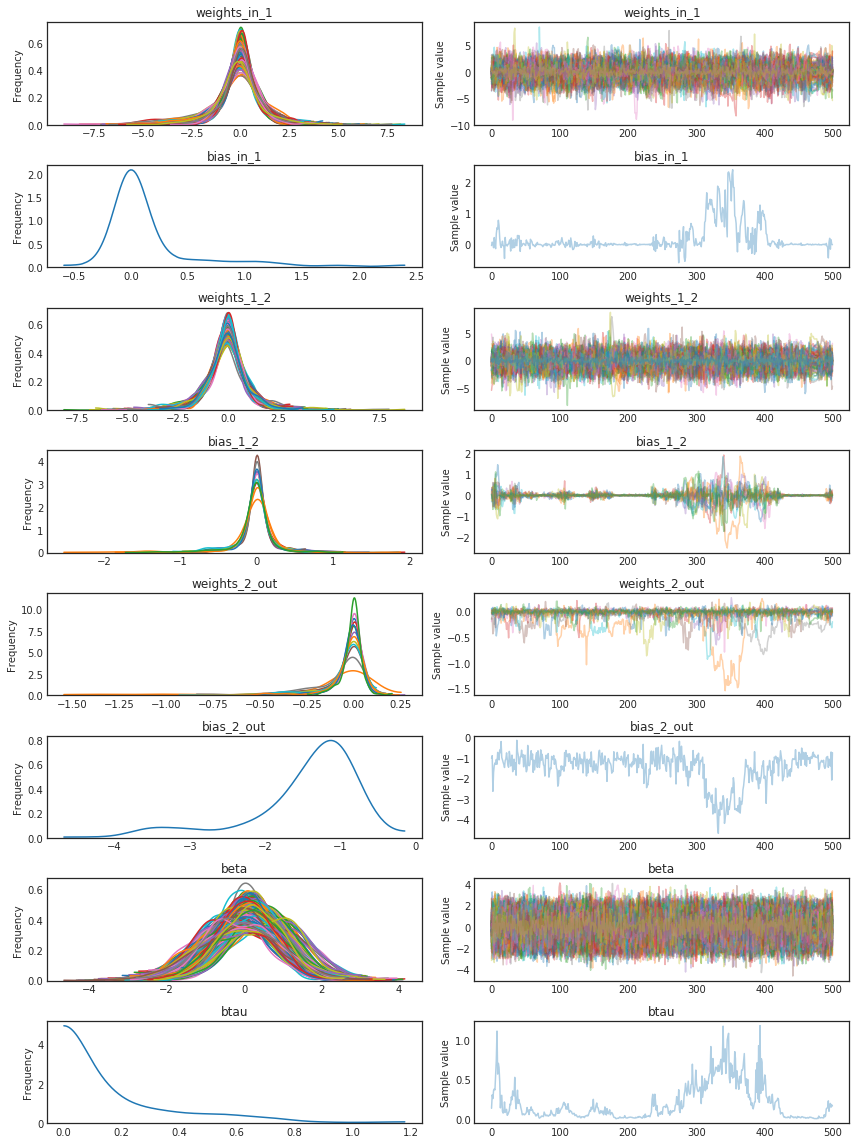

In [25]:
## traceplot
pm.traceplot(trace)

In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def nn_cv(n_splits=10):
    kf = KFold(n_splits=n_splits)
    acc = []
    spec = []
    sens = []
    aucs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test, group_train = X[train_index], X[test_index], group[train_index]
        Y_train, Y_test, group_test = Y[train_index], Y[test_index], group[test_index]
        ## sample
        ann_input.set_value(X_test)
        ann_output.set_value(Y_test)
        ann_group.set_value(group_test)
        with neural_network:
            ppc = pm.sample_ppc(trace, samples=1000, progressbar=True)
            p = ppc['likelihood'].mean(axis=0)
            # p = stats.mode(ppc['out'], axis=0).mode[0, :]
            # p = np.median(ppc['out'],axis=0)
            sd = ppc['likelihood'].std(axis=0)
            pred = (p > 0.5).astype(np.int)
        tn, fp, fn, tp = confusion_matrix(Y_test, pred).ravel()
        accuracy = (tp+tn)/len(Y_test)
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)
        auc = roc_auc_score(Y_test, pred)
        spec.append(specificity)
        sens.append(sensitivity)
        acc.append(accuracy)
        aucs.append(auc)
    return {'specificity':spec, 'sensitivity':sens, 'accuracy':acc, 'auc':aucs}

In [27]:
cv = nn_cv(10)
print("oos auc: ", np.mean(cv['auc']))
print("oos accuracy: ", np.mean(cv['accuracy']))
print("oos sensitivity: ", np.mean(cv['sensitivity']))
print("oos specificity: ", np.mean(cv['specificity']))

100%|██████████| 1000/1000 [00:00<00:00, 1322.34it/s]

oos auc:  0.9443178541895048
oos accuracy:  0.952
oos sensitivity:  0.8991366471057546
oos specificity:  0.9894990612732549


In [ ]:
## to-do: feature importance and relative risks from neural network (ie adapt Shapley value code)

In [28]:
## compare to frequentist poisson
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, test_size=.2, random_state=SEED, stratify=Y)
import statsmodels.api as sm
p1 = sm.GLM(Y_train, X_train, family = sm.families.Poisson())
m1 = p1.fit()

In [29]:
## Kfold crossval deviance for stats models
def sm_cv(n_splits=10):
    kf = KFold(n_splits=n_splits)
    acc = []
    spec = []
    sens = []
    aucs = []
    for train_index, test_index in kf.split(X_df):
        X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
        Y_train, Y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]   
        y_pred_prob = m1.predict(X_test)
        predictions = [round(value) for value in y_pred_prob]
        predictions = [1 if x>=.5 else x for x in predictions]
        predictions = [0 if x<.5 else x for x in predictions]
        tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
        accuracy = (tp+tn)/len(Y_test)
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)
        auc = roc_auc_score(Y_test, predictions)
        spec.append(specificity)
        sens.append(sensitivity)
        acc.append(accuracy)
        aucs.append(auc)

    return {'specificity':spec, 'sensitivity':sens, 'accuracy':acc, 'auc':aucs}

In [30]:
cvp = sm_cv(10)
print("oos auc: ", np.mean(cvp['auc']))
print("oos accuracy: ", np.mean(cvp['accuracy']))
print("oos sensitivity: ", np.mean(cvp['sensitivity']))
print("oos specificity: ", np.mean(cvp['specificity']))

oos auc:  0.8338966387196622
oos accuracy:  0.8539999999999999
oos sensitivity:  0.6745905124623659
oos specificity:  0.9932027649769584


In [31]:
## compare to xgboost
X_train, X_test, Y_train, Y_test = X_df.iloc[train_inds], X_df.iloc[test_inds], Y_df.iloc[train_inds], Y_df.iloc[test_inds]

import xgboost as xgb

## set xgboost parameters
params = {
    "n_jobs": CORES,
    "nthread": CORES,
    "objective": "count:poisson",
    "eval_metric": "poisson-nloglik",
    "silent": 1,
}

dtrain = xgb.DMatrix(X_train,label=Y_train)
dvalid = xgb.DMatrix(X_test,label=Y_test)

## run model
progress = dict()
bst = xgb.train(params, dtrain, 2000, [(dtrain, "train"),(dvalid, "valid")], evals_result=progress, verbose_eval=50, early_stopping_rounds = 500, maximize=False)


[0]	train-poisson-nloglik:0.738382	valid-poisson-nloglik:0.758826
Multiple eval metrics have been passed: 'valid-poisson-nloglik' will be used for early stopping.

Will train until valid-poisson-nloglik hasn't improved in 500 rounds.
[50]	train-poisson-nloglik:0.437939	valid-poisson-nloglik:0.640719
[100]	train-poisson-nloglik:0.434656	valid-poisson-nloglik:0.668803
[150]	train-poisson-nloglik:0.433027	valid-poisson-nloglik:0.693425
[200]	train-poisson-nloglik:0.432251	valid-poisson-nloglik:0.708924
[250]	train-poisson-nloglik:0.431773	valid-poisson-nloglik:0.725197
[300]	train-poisson-nloglik:0.431522	valid-poisson-nloglik:0.735966
[350]	train-poisson-nloglik:0.431311	valid-poisson-nloglik:0.746947
[400]	train-poisson-nloglik:0.431109	valid-poisson-nloglik:0.759745
[450]	train-poisson-nloglik:0.43098	valid-poisson-nloglik:0.76922
[500]	train-poisson-nloglik:0.430885	valid-poisson-nloglik:0.777848
Stopping. Best iteration:
[17]	train-poisson-nloglik:0.46815	valid-poisson-nloglik:0.5996

In [32]:
## Kfold crossval deviance
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def xg_cv(n_splits=10):
    kf = KFold(n_splits=n_splits)
    acc = []
    spec = []
    sens = []
    aucs = []
    for train_index, test_index in kf.split(X_df):
        X_train, X_test, Y_train, Y_test = X_df.iloc[train_index], X_df.iloc[test_index], Y_df.iloc[train_index], Y_df.iloc[test_index]
        ## sample
        dvalid = xgb.DMatrix(X_test,label=Y_test)
        y_pred_prob = bst.predict(dvalid)           
        predictions = [round(value) for value in y_pred_prob]
        predictions = [1 if x>=.5 else x for x in predictions]
        predictions = [0 if x<.5 else x for x in predictions]
        tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
        accuracy = (tp+tn)/len(Y_test)
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)
        auc = roc_auc_score(Y_test, y_pred_prob)
        spec.append(specificity)
        sens.append(sensitivity)
        acc.append(accuracy)
        aucs.append(auc)
    return {'specificity':spec, 'sensitivity':sens, 'accuracy':acc, 'auc':aucs}

In [33]:
cvxg = xg_cv(10)
print("oos auc: ", np.mean(cvxg['auc']))
print("oos accuracy: ", np.mean(cvxg['accuracy']))
print("oos sensitivity: ", np.mean(cvxg['sensitivity']))
print("oos specificity: ", np.mean(cvxg['specificity']))

oos auc:  0.996513213724589
oos accuracy:  0.968
oos sensitivity:  0.9236217729638782
oos specificity:  1.0
